In [1]:
import sys, os
COLAB = 'google.colab' in sys.modules 
if COLAB and 'procgen-tools' not in os.getcwd():
    os.system("git clone https://github.com/UlisseMini/procgen-tools")
    os.chdir('procgen-tools')
    %pip install -r requirements.txt

In [2]:
%load_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from procgen import ProcgenGym3Env
import envs.maze as maze
from models import load_policy
import torch
from IPython import display

building procgen...done


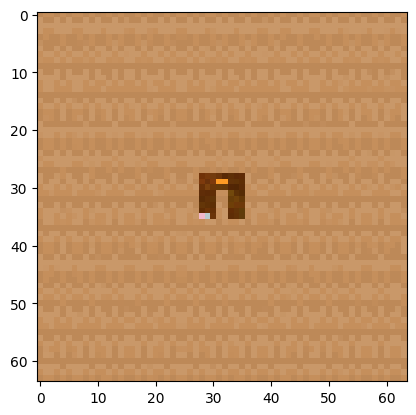

In [3]:
# num is the number of environments to create in the vec env
# num_levels is the number of levels to sample from (0 for infinite, 1 for deterministic)
venv = ProcgenGym3Env(
    num=1, env_name='maze', num_levels=0, start_level=0,
    distribution_mode='hard', num_threads=1, render_mode="rgb_array",
)
venv = maze.wrap_venv(venv)
obs = venv.reset()
# plot all the envs in the vectorized env
for i in range(obs.shape[0]):
    plt.imshow(obs[i].transpose(1, 2, 0))
    plt.show()

## Edit the maze interactively

Using the magic `maze.grid_editor` function!
Clicking in the maze changes walls to empty space and vise versa.
If you click the cheese it'll disappear and reappear where you click next.

In [4]:
state_bytes = venv.env.callmethod('get_state')[0]
state_vals = maze.parse_maze_state_bytes(state_bytes)
gridm = maze.get_grid_with_mouse(state_vals) # gridm because it includes the mouse
maze.grid_editor(gridm, node_radius='8px')

## Check that maze is in-distribution

The maze is generated using a variant of [Kruskal's algorithm](https://weblog.jamisbuck.org/2011/1/3/maze-generation-kruskal-s-algorithm). The algorithm results in some constraints on generated mazes we want to uphold, in order to stay in-distribution.
1. Squares where the row and column indices are both odd, e.g. (1,1), must always be blocked.
2. Squares where the row and column indices are both even, e.g. (0,0), must always be open.
3. Squares where the row and column indices are (odd, even) or (even, odd) may be open or blocked.
4. The maze must be fully-connected, i.e. there must be a path from every open square to every other open square.
5. The maze must not have any loops or cycles, i.e. there must be exactly one path between any two open squares.

These are all checked by the `maze.on_distribution` function.

In [5]:
assert maze.on_distribution(gridm), "Maze isn't on distribution!"

## Overwrite the env with the edited maze

If you don't do this `venv` will still be using the old state!

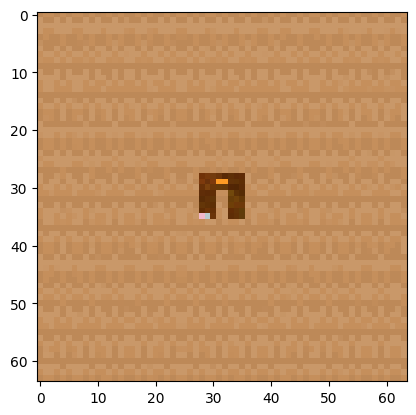

In [6]:
maze.set_grid_with_mouse(state_vals, gridm)
state_bytes = maze.serialize_maze_state(state_vals)
venv.env.callmethod("set_state", [state_bytes])

obs = venv.reset()
plt.imshow(obs[0].transpose(1, 2, 0))

## Run the model on the new maze

In [7]:
if COLAB:
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

In [8]:
# download from https://drive.google.com/file/d/1db1qJn_ZM49CUcA1k7uSMdsdiAQ4eR5a/view?usp=share_link
policy = load_policy('./models/model_200015872.pth', action_size=venv.action_space.n, device=torch.device('cpu'))


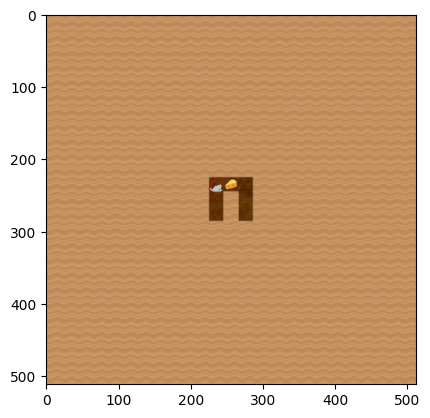

In [9]:
done = np.zeros(venv.num_envs)
obs = venv.reset()

while not all(done):
    policy.eval()
    p, v = policy(torch.FloatTensor(obs))
    act = p.sample().numpy()
    #act = p.probs.argmax(dim=-1).numpy()
    obs, rew, done_now, info = venv.step(act)
    done = np.logical_or(done, done_now) # TODO: Don't keep running finished envs 

    if not all(done): # don't show last frame (new maze)
        # plt.imshow(obs[0].transpose(1,2,0)) # agent view
        plt.imshow(info[0]['rgb'])
        display.display(plt.gcf())
        display.clear_output(wait=True)
